In [17]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation, Input
from keras.layers import Conv1D, LSTM, Dropout, TimeDistributed, RepeatVector
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.ensemble import IsolationForest
from keras import regularizers
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("./Data/WISDM.csv", index_col=0)
df

,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


In [3]:
df.isna().sum()

user-id      0
activity     0
timestamp    0
X            0
Y            0
Z            0
dtype: int64

In [4]:
df['activity'].value_counts()

Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64

In [5]:
df.rename(columns={'activity': 'label'}, inplace=True)
df

,user-id,label,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


In [6]:
df_sitting = df[df['label'] == 'Jogging'].sample(n=4500, random_state=42)
df_jogging = df[df['label'] == 'Sitting'].sample(n=4500, random_state=42)
len(df_sitting), len(df_jogging)

(4500, 4500)

In [7]:
df_train = pd.concat([df_sitting, df_jogging], axis=0)
df_train

,user-id,label,timestamp,X,Y,Z
110810,13,Jogging,0,0.00,0.00,0.000000
164275,6,Jogging,2694792247000,-0.46,-0.46,1.334794
813141,31,Jogging,23960721626000,19.08,18.35,2.910000
1002308,2,Jogging,9022662336000,3.06,-0.30,1.920000
815984,31,Jogging,24102851723000,-0.23,4.25,-4.710000
...,...,...,...,...,...,...
503398,32,Sitting,2480612315000,7.74,-1.95,4.560000
1051607,7,Sitting,209336691499000,-6.47,-3.26,6.850000
398029,5,Sitting,3079682232000,4.33,3.06,8.008764
570806,20,Sitting,58707702282000,0.00,4.21,9.110000


In [8]:
df_train['label'] = df_train['label'].replace({'Sitting': 0, 'Jogging': 1})
df_train

,user-id,label,timestamp,X,Y,Z
110810,13,1,0,0.00,0.00,0.000000
164275,6,1,2694792247000,-0.46,-0.46,1.334794
813141,31,1,23960721626000,19.08,18.35,2.910000
1002308,2,1,9022662336000,3.06,-0.30,1.920000
815984,31,1,24102851723000,-0.23,4.25,-4.710000
...,...,...,...,...,...,...
503398,32,0,2480612315000,7.74,-1.95,4.560000
1051607,7,0,209336691499000,-6.47,-3.26,6.850000
398029,5,0,3079682232000,4.33,3.06,8.008764
570806,20,0,58707702282000,0.00,4.21,9.110000


In [9]:
X_train, X_test = train_test_split(df_train, test_size=0.25, random_state=42)

In [10]:
X_train.shape, X_test.shape

((6750, 6), (2250, 6))

In [11]:
sitting = X_train[X_train['label'] == 0]

y_train = sitting['label']

X_train_sitting_train = sitting.drop(['label'], axis=1)

y_test = X_test['label']

X_test = X_test.drop(['label'], axis=1)
X_train_sitting_train.shape, X_test.shape

((3368, 5), (2250, 5))

In [12]:
features = ['X', 'Y', 'Z']

# 피쳐 선택
X_train_sitting = X_train_sitting_train[features]
X_test = X_test[features]
X_train_sitting

,X,Y,Z
892675,1.73,0.31,9.620000
640918,8.16,-1.99,3.980000
576284,-1.53,3.64,9.430000
1095958,8.96,-0.76,2.300000
573896,-0.99,3.72,9.470000
...,...,...,...
829166,0.84,-0.15,9.700000
459991,5.56,1.73,8.430000
253579,-4.86,-2.22,7.886181
469719,5.56,2.56,8.160000


In [13]:
# 표준화
scaler = StandardScaler()
X_train_sitting = scaler.fit_transform(X_train_sitting)
X_test = scaler.fit_transform(X_test)
X_train_sitting

array([[-0.02134624, -0.45921221,  0.82566489],
       [ 1.31267736, -1.17109903, -0.70441523],
       [-0.69769412,  0.5714761 ,  0.77411964],
       ...,
       [-1.38856482, -1.24228772,  0.35529585],
       [ 0.7732588 ,  0.23719881,  0.42958032],
       [ 1.46205481, -0.80277498, -1.16018378]])

In [14]:
from numpy import array
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


In [15]:
# Merge train and test X/y data to apply sequence transformation function
y_train_array = np.array(y_train)
train_set = np.c_[X_train_sitting, y_train_array]

y_test_array = np.array(y_test)
test_set = np.c_[X_test, y_test_array]

# Apply sequence transformation using time step of 25 for both train and test data
# All sensing modalities are recorded at a sampling rate of 50 Hz, which is considered sufficient for capturing human activity.

X_train, y_train = split_sequences(train_set, 25)
print(X_train.shape, y_train.shape)

X_test, y_test = split_sequences(test_set, 25)
print(X_test.shape, y_test.shape)

(3344, 25, 3) (3344,)
(2226, 25, 3) (2226,)


In [18]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [19]:
#create the autoencoder model

model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 3)]           0         
                                                                 
 lstm (LSTM)                 (None, 25, 16)            1280      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVector  (None, 25, 4)            0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 25, 4)             144       
                                                                 
 lstm_3 (LSTM)               (None, 25, 16)            1344      
                                                             

In [21]:
# fit the model to the data
nb_epochs = 20
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/20
318/318 [==============================] - 5s 16ms/step - loss: 0.7386 - val_loss: 0.7413
Epoch 2/20
318/318 [==============================] - 6s 20ms/step - loss: 0.7375 - val_loss: 0.7418
Epoch 3/20
318/318 [==============================] - 6s 20ms/step - loss: 0.7361 - val_loss: 0.7392
Epoch 4/20
318/318 [==============================] - 6s 17ms/step - loss: 0.7346 - val_loss: 0.7345
Epoch 5/20
318/318 [==============================] - 6s 20ms/step - loss: 0.7329 - val_loss: 0.7338
Epoch 6/20
318/318 [==============================] - 6s 20ms/step - loss: 0.7321 - val_loss: 0.7336
Epoch 7/20
318/318 [==============================] - 5s 17ms/step - loss: 0.7313 - val_loss: 0.7314
Epoch 8/20
318/318 [==============================] - 6s 19ms/step - loss: 0.7305 - val_loss: 0.7342
Epoch 9/20
318/318 [==============================] - 6s 20ms/step - loss: 0.7304 - val_loss: 0.7328
Epoch 10/20
318/318 [==============================] - 6s 19ms/step - loss: 0.7297 - val_lo

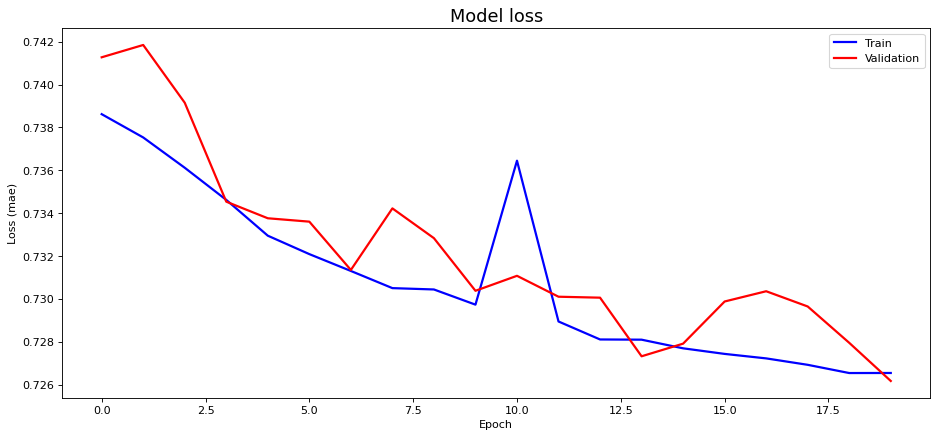

In [22]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [53]:
predictions = model.predict(X_test)
# 3차원 배열을 2차원 배열로 변환
# predictions = predictions.reshape(-1, predictions.shape[-1])
predictions

70/70 [==============================] - 0s 4ms/step


array([[[ 0.0883079 ,  0.1942635 ,  0.36701435],
        [ 0.12717749,  0.21470729,  0.37724674],
        [ 0.30725652,  0.21271415,  0.3625386 ],
        ...,
        [-0.64319694,  0.34762156,  0.5108402 ],
        [-0.64251924,  0.35735923,  0.50778913],
        [-0.64938396,  0.34637386,  0.5065713 ]],

       [[ 0.23615964,  0.1905767 ,  0.35604715],
        [ 0.41210562,  0.20480433,  0.34864315],
        [ 0.5587287 ,  0.20184678,  0.31043875],
        ...,
        [ 0.10430124,  0.3125378 ,  0.38958296],
        [ 0.25144398,  0.32883936,  0.36472628],
        [ 0.3282971 ,  0.3487519 ,  0.35517237]],

       [[ 0.26694712,  0.19049695,  0.35416365],
        [ 0.4460581 ,  0.20470701,  0.34219736],
        [ 0.5937846 ,  0.20083474,  0.29523998],
        ...,
        [ 0.1312758 ,  0.33399796,  0.39039776],
        [ 0.18388875,  0.3548981 ,  0.38640767],
        [ 0.14864421,  0.38010293,  0.40163246]],

       ...,

       [[-0.14942957,  0.2244092 ,  0.4371777 ],
        [-0

In [56]:
X_test

array([[[ 0.33900696,  0.78876029, -0.29465691],
        [-0.95294567,  0.65002906,  0.15640261],
        [-0.10693895,  1.31316431, -1.24424109],
        ...,
        [-1.10637401, -0.94399268,  0.582139  ],
        [-0.79234779, -0.01449349,  0.8222343 ],
        [ 0.33900696,  0.78876029, -0.32623106]],

       [[-0.95294567,  0.65002906,  0.15640261],
        [-0.10693895,  1.31316431, -1.24424109],
        [ 0.47522838,  0.5862127 ,  0.30230379],
        ...,
        [-0.79234779, -0.01449349,  0.8222343 ],
        [ 0.33900696,  0.78876029, -0.32623106],
        [ 1.20508842,  2.21630457, -1.21940365]],

       [[-0.10693895,  1.31316431, -1.24424109],
        [ 0.47522838,  0.5862127 ,  0.30230379],
        [-1.10637401, -0.97173893,  0.59372981],
        ...,
        [ 0.33900696,  0.78876029, -0.32623106],
        [ 1.20508842,  2.21630457, -1.21940365],
        [-0.03524347, -0.51947514,  1.10206951]],

       ...,

       [[-0.00799919, -0.53057364,  1.08385538],
        [-1

In [68]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
# 각 행을 평균하여 1차원 배열로 바꾸기
mse = np.mean(mse, axis=1)
mse

array([0.82957861, 0.89285342, 0.89324881, ..., 1.30383528, 1.34381475,
       1.28527606])

In [69]:
np.mean(mse), len(mse)

(1.042990437465979, 2226)

In [70]:
threshold = 1.0429904374659793

In [71]:
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

LABELS = ["Sitting", "Jogging"]

y_pred = [1 if e > threshold else 0 for e in mse.flatten()]
len(y_pred)


2226

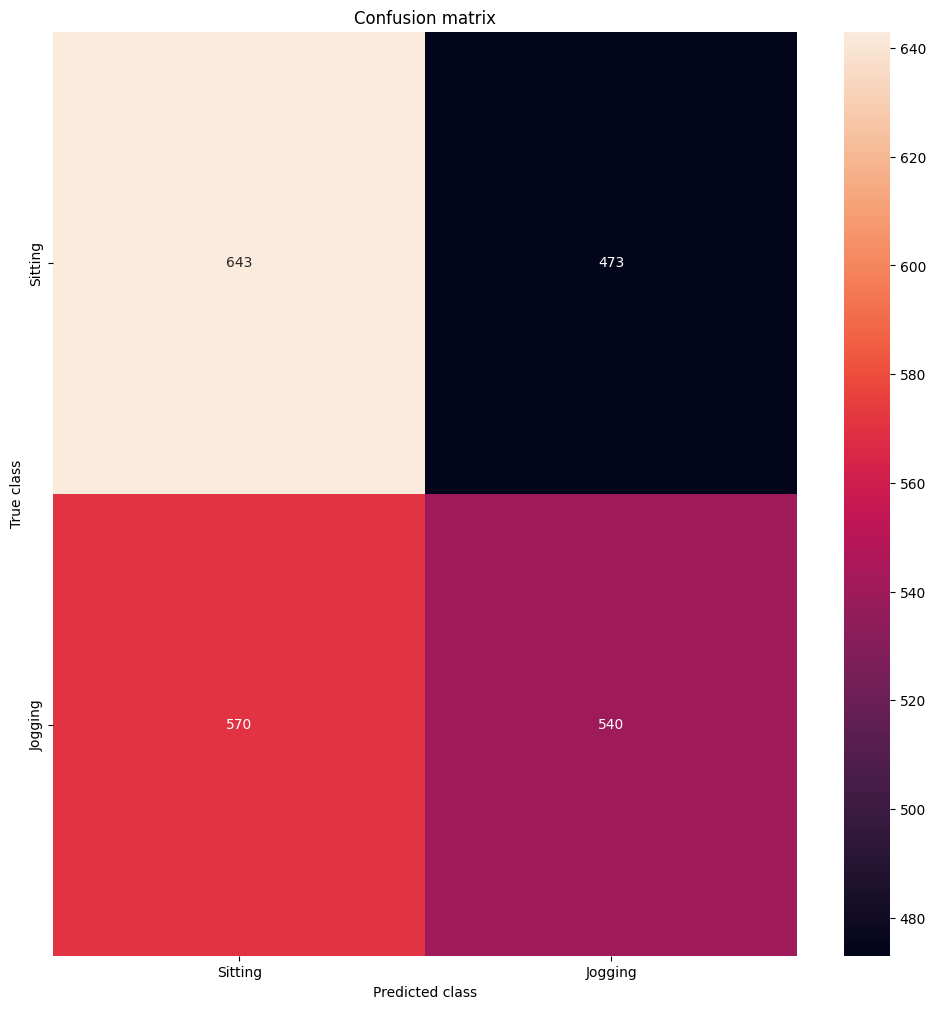

In [72]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


In [74]:
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import accuracy_score

precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')

print ('Accuracy Score :',accuracy_score(y_test, y_pred) )

print ('Precision :',precision )

print ('Recall :',recall )

print ('F1 :',f1 )

Accuracy Score : 0.5314465408805031
Precision : 0.5330700888450148
Recall : 0.4864864864864865
F1 : 0.5087140838436176
